## <center> Take-home Midterm </center>
<center> Tara Wilson </center>
<center> DATA 558 </center>
<center> May 9, 2019 </center>

In [1]:
# imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.linalg import eigh
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statistics import mean
from collections import Counter
import warnings
import copy 
import os
warnings.filterwarnings('ignore')

### Exercise 1

**In this exercise, you will implement in Python a first version of your own $l_2^2$-regularized binary logistic regression with ρ-logistic loss. You will write your own codes for all functions: accelerated gradient algorithm,  $l_2^2$-regularized binary logistic regression with ρ-logistic loss, leave-one-out cross-validation, and hold-out cross-validation.The  $l_2^2$-regularized binary logistic regression with ρ-logistic loss is a supervised binary classification method, similar to  $l_2^2$-regularized binary logistic regression.**

$min F(\beta) := \frac{1}{n} \sum_{i=1}^{n} \frac{1}{\rho} log(1 + exp(-\rho y_ix_i^T\beta)) +  \lambda ||\beta||_2^2$  

**You know now by heart the accelerated gradient algorithm, so no need to recall it here.**

**Compute the gradient $\nabla F(\beta)$ of $F$.**

To calculate the gradient we will take the derivative of $F$ with respect to $\beta$,   
$F'(\beta) := \frac{\partial}{\partial \beta} \frac{1}{n} \sum_{i=1}^{n} \frac{1}{\rho} log(1 + exp(-\rho y_ix_i^T\beta)) + \frac{\partial}{\partial \beta} \lambda ||\beta||_2^2$

Since the $\frac{1}{n} \sum_{i=1}^{n} \frac{1}{\rho}$ terms are constants in terms of the derivative we can rearrange:  
$F'(\beta) := \frac{1}{n} \sum_{i=1}^{n} \frac{1}{\rho} \frac{\partial}{\partial \beta} log(1 + exp(-\rho y_ix_i^T\beta)) + \frac{\partial}{\partial \beta} \lambda ||\beta||_2^2$

I will start by breaking the derivitive into 2 sections:  
$h'(\beta) = \frac{\partial}{\partial \beta}  \frac{1}{\rho} log(1 + exp(-\rho y_ix_i^T\beta))$  
$g'(\beta) = \frac{\partial}{\partial \beta} \lambda ||\beta||_2^2$   

---

We will start again with the derivative of h where we will need to apply the chain rule where $h(\beta) = f(m(j(\beta)))$: 
In our case, $f = log(...)$, $m = 1 + exp(...)$, and $j = -\rho y_i x_i^T\beta$ and we want to solve for $j(x)*m'(j(x))*f'(m(j(x))$.  

Starting with $j(x)$ and pulling out the terms that are constants ($\rho y$) with respect to $\beta$ and then applying the fact that $\frac{\partial}{\partial x} (a^Tx) = a$:  
$j'(\beta) = \frac{\partial}{\partial \beta} -\rho y_i x_i^T\beta = -\rho y_ix_i$  

Now for $m'(j(x))$:  
$m'(j(\beta)) = \frac{\partial}{\partial \beta} 1 + \exp(-\rho y_ix_i^T\beta) = exp(-\rho y_i x_i^T\beta)$

For the last term $f'(m(j(x))$ we have:  
$f'(m(j(\beta) = \frac{\partial}{\partial \beta} \log(1 + \exp(-\rho y_i x_i^T\beta)) = \frac{1}{1+\exp(-\rho y_ix_i^T\beta)}$  

Putting this all back together we have the derivative of the first term:  
$h'(\beta) = (-\rho y_ix_i)(exp(-\rho y_ix_i^T\beta)(\frac {1}{1+ \exp (-\rho y_ix_i^T\beta)}) = \frac {-\rho y_ix_iexp(-\rho y_ix_i^T\beta)}{1+ \exp (-\rho y_ix_i^T\beta)}$  

---

Finally, solving for the derivative ofthe second term:  
$g'(\beta) = \frac{\partial}{\partial \beta} \lambda ||\beta||_2^2 = \lambda \beta^T \beta$  
We know the identity $\frac{\partial x^TAx}{\partial x} = (A + A^T)x$ and can apply this to our formula with $x = \beta$ and $A = $Identity matrix:  
$g'(\beta) = \lambda \frac{\partial \beta^T Id \beta}{\partial x} = \lambda (Id^T + Id)\beta$  
We know the Identity matrix is just a diagonal of ones and the transpose is the same so summing these gives us a matrix with a diagonal of 2's:  
$g'(\beta) = \lambda 2Id * \beta = 2\lambda \beta$

---

Putting these together we arrive at the gradient of F:  
$\nabla F = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{\rho} \frac {-\rho y_ix_iexp(-\rho y_ix_i^T\beta)}{1+ \exp (-\rho y_ix_i^T\beta)} + 2 \lambda \beta$   
The rho terms inside the summation will simplify and we get our final result as:  
$\nabla F = \frac{1}{n} \sum_{i=1}^{n} \frac {-y_ix_iexp(-\rho y_ix_i^T\beta)}{1+ \exp (-\rho y_ix_i^T\beta)} + 2 \lambda \beta$  

**Consider the `Spam` dataset from *The Elements of Statistical Learning*. Standardize the data,
if you have not done so already. Be sure to use the training and test splits from the website.
You can find the link to the train/test split here: `https://web.stanford.edu/~hastie/ElemStatLearn/data.html`**

In [2]:
# read in Spam data
spam = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data", sep=" ", na_values="?", header=None)
spam = spam.dropna()

# bring in train test split from website
trainTestInd = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.traintest", sep= " ", header=None)
spam = np.hstack((spam, trainTestInd))

# seperate train and test using website indicator
trainSpam = spam[spam[:,-1] == 0]
testSpam = spam[spam[:,-1] == 1]

# grab X values
X_train = trainSpam[:, 0:57]
X_test = testSpam[:, 0:57]

# grab y values, replace 0's and 1's with -1's and 1's
y_train = (trainSpam[:,-2])
y_train = y_train.reshape((len(y_train), 1))
y_train[y_train == 0] = -1
y_test = testSpam[:,-2]
y_test = y_test.reshape((len(y_test), 1))
y_test[y_test == 0] = -1

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# standardizing X by subtracting the mean of the predictors and dividing by their standard deviation
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train shape:  (3065, 57)
X_test shape:  (1536, 57)
y_train shape:  (3065, 1)
y_test shape:  (1536, 1)


**Write a function *myrhologistic* that implements the accelerated gradient algorithm to train $l_2^2$-regularized binary logistic regression with ρ-logistic loss. The function takes as input the initial step-size for the backtracking rule, the ε for the stopping criterion based on the norm of the gradient of the objective, and the value of ρ.**

In [3]:
def myrhologistic(X, y, stepSize, targetAccuracy, rho, lamb):
    """
    Implements accelerated gradient descent algorithm with backtracking
    for l-2 regularized binary logistic regression with p-logistic loss
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - stepSize: initial step size
        - targetAccuracy: target accuracy value for algorithm
        - rho: factor for logistic loss
        - lambda: scalar multiplicative factor for regularization penalty
    Outputs:
        - betas: vector of improved betas after each iteration
        - objs: vector of objective values for each iteration
    """
    beta = np.zeros((X.shape[1], 1))
    theta = np.zeros((X.shape[1], 1))
    objs = [computeobj(X, y, beta, rho, lamb)]
    betas = [beta]
    grad = computegrad(X, y, beta, rho, lamb)
    t = 0
    while (np.linalg.norm(grad) > targetAccuracy):
        stepSize = backtracking(X, y, beta, stepSize, rho, lamb)
        betaOld = copy.copy(beta)
        beta = theta - stepSize * computegrad(X, y, theta, rho, lamb)
        theta = beta + (t/(t+3))*(beta - betaOld)
        betas.append(beta) # saves current beta values
        obj = computeobj(X, y, beta, rho, lamb)
        objs.append(obj) # saves current objective value
        grad = computegrad(X, y, beta, rho, lamb)
        t += 1
    return np.array(betas), np.array(objs)

In [4]:
def computegrad(X, y, beta, rho, lamb):
    """
    Computes the gradient for the fast gradient algorithm
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - rho: value of rho-logistic loss parameter
        - lambda: scalar multiplicative factor for regularization penalty
    Outputs:
        - vector of gradient for passed in parameters
    """
    n = len(X)
    summation = 0
    for i in range(0, X.shape[0]):
        xi = X[i,:]
        yi = y[i]
        expTerm = ((np.exp(-rho * yi * (xi.T).dot(beta))) / (1 + (np.exp(-rho * yi * (xi.T).dot(beta)))))
        summation += yi * xi * expTerm
    summation = summation.reshape(summation.shape[0], 1)
    return ((-1/n) * summation + (2*lamb*beta).reshape(summation.shape[0],1))

In [5]:
def computeobj(X, y, beta, rho, lamb):
    """
    Computes the objective for rho logistic loss problem
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - rho: value of rho-logistic loss parameter
        - lambda: scalar multiplicative factor for regularization penalty
    Outputs:
        - objective for passed in parameters
    """
    n = len(X)
    summation = 0
    for i in range(0, n):
        xi = X[i,:]
        yi = y[i]
        x = -rho*yi*xi.T.dot(beta)
        logTerm = np.log(1 + np.exp(x))
        summation = summation + logTerm
    return ((1/(n * rho)) * summation + (lamb * np.sum(beta**2)))[0]

In [6]:
def backtracking(X, y, beta, eta, rho, lamb, alpha = 0.5, gamma=0.8):
    """
    Implements backtracking rule
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes
        - beta: vector of beta constants
        - eta: initial step size
        - rho: value of rho-logistic loss parameter
        - lambda: scalar multiplicative factor for regularization penalty
        - alpha: constant used to define sufficinet decrease condition, default set to 0.5
        - gamma: constant to scale step size by until condition met, default set to 0.8
    Outputs:
        - step size
    """
    grad = computegrad(X, y, beta, rho, lamb)  # calculates the gradient at current beta
    conditionMet = False # tracks when we find the backtracked step size
    while not conditionMet: 
        if computeobj(X, y, beta - eta*grad, rho, lamb) < (computeobj(X, y, beta, rho, lamb) - alpha*eta*np.linalg.norm(grad)**2):
            conditionMet = True
        else:
            eta = eta * gamma            
    return eta

**Train your $l_2^2$-regularized binary logistic regression with ρ-logistic loss with ρ = 2 and ε = 10−3
on the the Spam dataset for the λ = 1. Report your misclassification error for this value of λ.**

In [7]:
# set constants
rho = 2
epsilon = 0.001
lamb = 1

# calculate starting step size for training X values
n = len(X_train)
eq = (1/n * X_train.T.dot(X_train))
eigenVals = eigh(eq)[0]
initialStepSize = 1 / (max(eigenVals) + lamb)

# train algorithm
trainBetas, trainObjs = myrhologistic(X_train, y_train, initialStepSize, epsilon, rho, lamb)

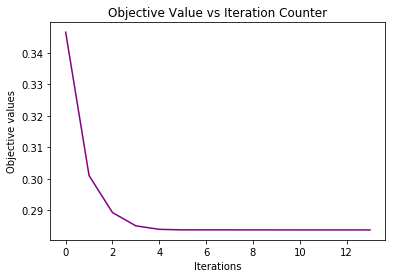

In [8]:
# plot objective values to verify they are decreasing properly
plt.plot(trainObjs, color = "purple")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter")
plt.show()

Here we see the objective value is decreasing as the number of iterations increase as we would expect. The function looks like it converges around 13 iterations which is pretty quick and is consistant with the large lambda value.

In [9]:
def calcMisclassificationError(X, y, betas):
    """
    Calculates the misclassification error for a binary response variable
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes, binary
        - betas: coefficients that correspond to X values
    Outputs:
        - misclassifications: ratio of incorrect values / total values for all betas
    """
    misclassifications = np.zeros((betas.shape[0], 1))
    for b in range(betas.shape[0]):
        betaVals = betas[b]
        incorrect = 0
        for i in range(X.shape[0]):
            prediction = np.sum(np.dot(X[i], betaVals))
            if(prediction > 0): # maps the 0 and 1 values to -1 and 1
                prediction = 1
            else:
                prediction = -1
            if(prediction != y[i]):
                incorrect +=1
        misclassifications[b,:] = (incorrect / X.shape[0])
    return misclassifications

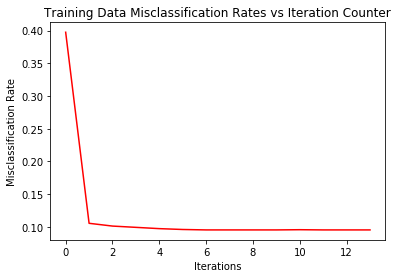

In [10]:
# calculate misclassification error
trainMisclassification = calcMisclassificationError(X_train, y_train, trainBetas)

# plot misclassification error
plt.plot(trainMisclassification, color = "red")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter")
plt.show()

The misclassification rate lowers as the number of iterations increases which is also expected behavior since our function should be optimizing for the ideal beta coefficients for our function. The rate seems to even out around .1, which is 10% misclassification. This seems reasonable, especially considering we are using a non-optimized lambda value of 1.

**Write a function *crossval* that implements leave-one-out cross-validation and hold-out crossvalidation. You may either write a function that implements each variant separately depending on the case, or write a general cross-validation function that can be instantiated in each case.**

In [11]:
def leaveOneOutCrossValidation(X, y, lambdas, epsilon, rho):
    """
    Finds optimal value of lambda from input options using leave one out cross validation method
    Inputs:
        - X: x-data used to train model
        - y: y-data used to train model
        - lambdas: array of lambda values to try as optimal value
        - epsilon: target accuracy for stopping criteria of logistic regression
        - rho: value of rho parameter to train logistic loss model with
    Outputs:
        - optimized lambda value chosen from input array
    """
    optimizedLamb = 0
    misclassificationRate = 1 # set this at max
    for lamb in lambdas:
        # calculates Beta values once per lambda since they should not vary much with one row missing each iteration
        n = len(X)
        eq = (1/n * X.T.dot(X))
        eigenVals = eigh(eq)[0]
        initialStepSize = 1 / (max(eigenVals) + lamb) # gets initial step size for each value of lambda
        # trains model to get coefficients with all data together
        modelBetas, modelObjs = myrhologistic(X, y, initialStepSize, epsilon, rho, lamb)
        scores = []
        for i in range(len(X)):  
            xRow = X[i]
            yRow = y[i][0]
            prediction = np.sum(np.dot(xRow, modelBetas[-1]))
            score = 1
            if(prediction > 0): # maps the 0 and 1 values to -1 and 1
                prediction = 1
            else:
                prediction = -1
            if(prediction == yRow):
                score = 0
            scores.append(score)
        if(mean((scores)) < misclassificationRate):
            misclassificationRate = mean((scores))
            optimizedLamb = lamb
    return optimizedLamb

I optimized the leave-one-out method by using the same betas for all leave one out combinations. The coefficients are recalculated for each lambda value as they will have a strong impact in this. Since n is large in both cases where I call this function in this assignment, I am using the assumption that removing one row of data would not change the beta values by much.  

I attempted to not make this adjustment but after running my code on AWS for almost an entire day and having it still not complete, I made this alteration in the interst of time and cost. However, I ran small subsets of the data with the betas being recalculated each iteration and my results were consistant. My main takeaway from this, as we would expect, is that leave one out cross validation is not a great method for large sample sizes.

In [12]:
def holdOutCrossValidation(X, y, lambdas, epsilon, rho):
    """
    Finds optimal value of lambda from input options using hold out cross validation method
    Inputs:
        - X: x-data used to train model
        - y: y-data used to train model
        - lambdas: array of lambda values to try as optimal
        - epsilon: target accuracy for stopping criteria of logistic regression
        - rho: value of rho parameter to train logistic loss model with
    Outputs:
        - optimized lambda value chosen from input array
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80%/20% split
    optimizedLamb = 0
    misclassificationRate = 1 # set this at max
    for lamb in lambdas:  
        n = len(X_train)
        eq = (1/n * X_train.T.dot(X_train))
        eigenVals = eigh(eq)[0]
        initialStepSize = 1 / (max(eigenVals) + lamb)
        modelBetas, modelObjs = myrhologistic(X_train, y_train, initialStepSize, epsilon, rho, lamb)
        modelMisclassification = calcMisclassificationError(X_test, y_test, modelBetas)
        if(modelMisclassification[-1] < misclassificationRate):
            misclassificationRate = modelMisclassification[-1]
            optimizedLamb = lamb
    return optimizedLamb

**Find the optimal value of λ using leave-one-out cross-validation. Find the optimal value of λ
using hold-out cross-validation with a 80%/20% split for the training set/testing set. Report
your misclassification errors for the two values of λ found.**

In [13]:
# leave one out cross validation
lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lOOLamb = leaveOneOutCrossValidation(X_train, y_train, lambdas, 0.001, 2)

print("Optimal value of lambda from leave-one-out cross validation:", lOOLamb)

# find starting step size for new lambda from leave one out cross validation
n = len(X_train)
eq = (1/n * X_train.T.dot(X_train))
eigenVals = eigh(eq)[0]
lOOInitialStepSize = 1 / (max(eigenVals) + lOOLamb)

# train algorithm
lOOBetas, lOOObjs = myrhologistic(X_train, y_train, lOOInitialStepSize, epsilon, rho, lOOLamb)

Optimal value of lambda from leave-one-out cross validation: 1e-06


In [14]:
# hold out cross validation
lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
hOLamb = holdOutCrossValidation(X_train, y_train, lambdas, 0.001, 2)

print("Optimal value of lambda from hold-out cross validation:", hOLamb)

# find starting step size for new lambda from hold out cross validation
n = len(X_train)
eq = (1/n * X_train.T.dot(X_train))
eigenVals = eigh(eq)[0]
hOInitialStepSize = 1 / (max(eigenVals) + hOLamb)

# train algorithm
hOBetas, hOObjs = myrhologistic(X_train, y_train, hOInitialStepSize, epsilon, rho, hOLamb)

Optimal value of lambda from hold-out cross validation: 1e-06


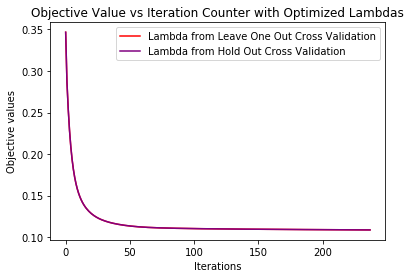

In [15]:
# plot objective values
plt.plot(lOOObjs, color = "red")
plt.plot(hOObjs, color = "purple")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter with Optimized Lambdas")
plt.legend(["Lambda from Leave One Out Cross Validation", "Lambda from Hold Out Cross Validation"])
plt.show()

The lambda from hold out cross validation converges in less iterations than that found from the leave one out method which is consistant with the hold-out method seelcting a larger lambda value. The lambda from the leave one out method also reaches a slightly lower final objective value but they decrease at very similar rates.

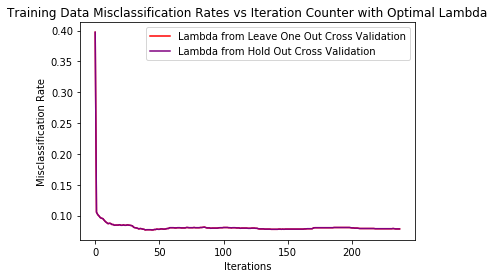

In [16]:
# calculate misclassification error on training set
lOOMisclassification = calcMisclassificationError(X_train, y_train, lOOBetas)
hOMisclassification = calcMisclassificationError(X_train, y_train, hOBetas)
        
# plot misclassification curves
plt.plot(lOOMisclassification, color = "red")
plt.plot(hOMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Lambda from Leave One Out Cross Validation", "Lambda from Hold Out Cross Validation"])
plt.show()

The misclassification rates are almost identical for the models trained with the lambda values found using the leave one out vs the hold out cross validation methods. This makes me confident that the method of choice for choosing the best lambda value will not have huge impact on my algorithm going forward.

### Data Competition Project

In [17]:
# read in Kaggle image data
data_dir = "../Kaggle/data_competition1_files"

x_train_unfiltered = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train_unfiltered = np.load(os.path.join(data_dir, 'train_labels.npy'))
x_test_unfiltered = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test_unfiltered = np.load(os.path.join(data_dir, 'val_labels.npy'))

kaggleTest = np.load(os.path.join(data_dir, 'test_features.npy'))

# filter testing data to two classes: 4, 7
x_train = np.zeros((1000, x_train_unfiltered.shape[1]))
y_train = np.zeros((1000, 1))
index = 0
for i in range(y_train_unfiltered.shape[0]):
    if(y_train_unfiltered[i] == 4 or y_train_unfiltered[i] == 7):
        x_train[index, :] = x_train_unfiltered[i].T
        y_train[index, :] = y_train_unfiltered[i]
        index += 1

y_train[y_train == 4] = -1
y_train[y_train == 7] = 1

# filter testing data to two classes: 4, 7
x_test = np.zeros((200, x_test_unfiltered.shape[1]))
y_test = np.zeros((200, 1))
index = 0

for i in range(y_test_unfiltered.shape[0]):
    if(y_test_unfiltered[i] == 4 or y_test_unfiltered[i] == 7):
        x_test[index, :] = x_test_unfiltered[i].T
        y_test[index, :] = y_test_unfiltered[i]
        index += 1

# reset y data to -1 and 1 to fit machine learning standards
y_test[y_test == 4] = -1
y_test[y_test == 7] = 1

# check dimensions
print("Number of images in x_train:", x_train.shape[0])
print("Dimension of features:", x_train.shape[1])

# standardize x values
xScaler = preprocessing.StandardScaler()
X_train = xScaler.fit_transform(x_train)
X_test = xScaler.transform(x_test)

Number of images in x_train: 1000
Dimension of features: 4096


**Pick two classes of your choice from the dataset. Train a classifier using $l_2^2$-regularized binary
logistic regression with ρ-logistic loss on the training set using your own accelerated gradient
algorithm with ρ = 2, ε = 10−3, and λ = 1. Be sure to use the features you previously generated with the provided script rather than the raw image features. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.**

In [18]:
# set constants
rho = 2
epsilon = .001
lamb = 1

# calculate starting step size for training data
n = len(X_train)
eq = (1/n * X_train.T.dot(X_train))
eigenVals = eigh(eq)[0]
kaggleTrainInitialStepSize = 1 / (max(eigenVals) + lamb)

# train algorithm with training data
kaggleTrainBetas, kaggleTrainObjs = myrhologistic(X_train, y_train, kaggleTrainInitialStepSize, epsilon, rho, lamb)

In [19]:
# calculate starting step size for validation data
n = len(X_test)
eq = (1/n * X_test.T.dot(X_test))
eigenVals = eigh(eq)[0]
kaggleTestInitialStepSize = 1 / (max(eigenVals) + lamb)

# train algorithm with training data
kaggleTestBetas, kaggleTestObjs = myrhologistic(X_test, y_test, kaggleTestInitialStepSize, epsilon, rho, lamb)

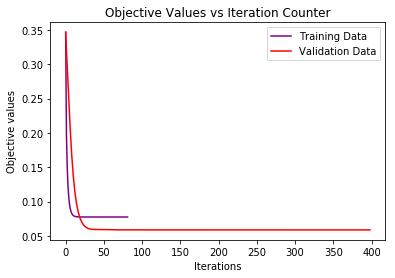

In [20]:
# plot objective values to verify they are decreasing properly
plt.plot(kaggleTrainObjs, color = "purple")
plt.plot(kaggleTestObjs, color = "red")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.legend(["Training Data", "Validation Data"])
plt.title("Objective Values vs Iteration Counter")
plt.show()

Here we can see that the objective values for both the training and validation data decrease as the number of iterations increases which is the expected behavior for our data. The validation data gets to a slightly lower objective value which is a good sign that our coefficients are not overfit to the training data. The validation data also runs for many more iterations which I'm guessing could be a product of the initial step size and smaller sample size taking longer to reach the target accuracy since the rest of the constants are the same for both.

In [21]:
def calcKaggleMisclassificationError(X, y, betas):
    """
    Calculates the misclassification error for a 0-9 response variable
    Inputs:
        - X: matrix of X values
        - y: vector of associated outcomes, 0-9
        - betas: coefficients that correspond to X values
    Outputs:
        - misclassifications: ratio of incorrect values / total values for all betas
    """
    misclassifications = np.zeros((betas.shape[0], 1))
    for b in range(betas.shape[0]):
        betaVals = betas[b]
        incorrect = 0
        for i in range(X.shape[0]):
            prediction = np.sum(np.dot(X[i], betaVals))
            if(prediction > 0):
                prediction = 1
            else:
                prediction = -1
            if(prediction != y[i]):
                incorrect +=1
        misclassifications[b,:] = (incorrect / X.shape[0])
    return misclassifications

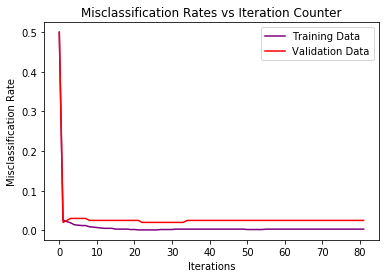

In [22]:
# calculate misclassification errors
kaggleTrainMisclassification = calcKaggleMisclassificationError(X_train, y_train, kaggleTrainBetas)
kaggleTestMisclassification = calcKaggleMisclassificationError(X_test, y_test, kaggleTrainBetas)

# plot misclassification error
plt.plot(kaggleTrainMisclassification, color = "purple")
plt.plot(kaggleTestMisclassification, color = "red")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Misclassification Rates vs Iteration Counter")
plt.legend(["Training Data", "Validation Data"])
plt.show()

Here, the misclassification rates are very suprisingly low for both (likely an effect of having only two classes) the training and validation data and decreases with the number of iterations as we would expect since the beta coefficients will become a better fit with each iteration. The values are also very similar for both train and validation data which is a good sign the model is not over or under fitting.

**Find the value of the regularization parameter λ using using leave-one-out cross-validation. Find the value of the regularization parameter λ using using hold-out cross-validation. Train a classifier using $l_2^2$-regularized binary logistic regression with ρ-logistic loss on the training set using your own accelerated gradient algorithm with that value of λ found by hold-out cross-validation. Plot, with different colors, the misclassification error on the training set and on the validation set vs. iterations.**

In [23]:
# leave one out cross validation
lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lOOLamb = leaveOneOutCrossValidation(X_train, y_train, lambdas, epsilon, rho)

print("Optimal value of lambda from leave-one-out cross validation:", lOOLamb)

# find starting step size for new lambda from leave one out cross validation
n = len(X_train)
eq = (1/n * X_train.T.dot(X_train))
eigenVals = eigh(eq)[0]
lOOInitialStepSize = 1 / (max(eigenVals) + lOOLamb)

# train algorithm
lOOBetas, lOOObjs = myrhologistic(X_train, y_train, lOOInitialStepSize, epsilon, rho, lOOLamb)

Optimal value of lambda from leave-one-out cross validation: 1e-06


In [ ]:
# hold out cross validation
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
hOLamb = holdOutCrossValidation(X_train, y_train, lambdas, epsilon, rho)

print("Optimal value of lambda from hold-out cross validation:", hOLamb)


# find starting step size for new lambda from hold out cross validation
n = len(X_train)
eq = (1/n * X_train.T.dot(X_train))
eigenVals = eigh(eq)[0]
hOInitialStepSize = 1 / (max(eigenVals) + hOLamb)

# train algorithm
hOBetas, hOObjs = myrhologistic(X_train, y_train, hOInitialStepSize, epsilon, rho, hOLamb)

In [ ]:
# plot objective values
plt.plot(lOOObjs, color = "red")
plt.plot(hOObjs, color = "purple")
plt.ylabel("Objective values")
plt.xlabel("Iterations")
plt.title("Objective Value vs Iteration Counter")
plt.legend(["Lambda from Leave One Out Cross Validation", "Lambda from Hold Out Cross Validation"])
plt.show()

The lambdas found using the hold-out method and leave-one-out method are very similar and exhibit almost identical objective behavior. The model trained with the lambda found with the leave one out method takes a few more iterations to converge but they decrease at an almost identical rate.

In [ ]:
# calculate misclassification error on training set
hOTrainMisclassification = calcKaggleMisclassificationError(X_train, y_train, hOBetas)
hOTestMisclassification = calcKaggleMisclassificationError(X_test, y_test, hOBetas)
        
# plot misclassification curves
plt.plot(hOTrainMisclassification, color = "red")
plt.plot(hOTestMisclassification, color = "purple")
plt.ylabel("Misclassification Rate")
plt.xlabel("Iterations")
plt.title("Training Data Misclassification Rates vs Iteration Counter with Optimal Lambda")
plt.legend(["Train Data", "Validation Data"])
plt.show()

Here we can see that the model fits the training and validation models very well, with close to 0 misclassification rate. The validation model shows a slighly higher misclassification rate which is expected behavior since the model was not trained with this data.

**Consider all pairs of classes from the dataset. For each pair of classes, train a classifier using
a $l_2^2$-regularized binary logistic regression with ρ-logistic loss on the training set comprising
only the data-points for that pair of classes using your own fast gradient algorithm. For each pair of classes, find the value of the regularization parameter λ using hold-out cross-validation on the training set comprising only the data-points for that pair of classes.**

In [ ]:
def getData(label1, label2):
    """
    Gets training and test data from kaggle dataset filtered by 2 specified labels
    Inputs:
        - label1: first label for filtering kaggle image dataset (0 - 9)
        - label2: second label for filtering kaggle image dataset (0 - 9), must be different than label1
    Outputs:
        - X_train: 75% of filtered x values to use for model training
        - X_test: 25% of filtered x values to use for model testing
        - y_train: 75% of filtered y values to use for model training
        - y_test: 25% of filtered y values to use for model testing
    """
    #filters x training values down to rows with matching input labels
    x_train = np.zeros((1000, x_train_unfiltered.shape[1]))
    y_train = np.zeros((1000, 1))
    index = 0
    for i in range(y_train_unfiltered.shape[0]):
        if(y_train_unfiltered[i] == label1 or y_train_unfiltered[i] == label2):
            x_train[index, :] = x_train_unfiltered[i].T
            y_train[index, :] = y_train_unfiltered[i]
            index += 1
    
    # reset train y data to -1 and 1 to fit machine learning standards
    y_train[y_train == label1] = -1
    y_train[y_train == label2] = 1

    #filters x testing values down to rows with matching input labels
    x_test = np.zeros((200, x_test_unfiltered.shape[1]))
    y_test = np.zeros((200, 1))
    index = 0
    for i in range(y_test_unfiltered.shape[0]):
        if(y_test_unfiltered[i] == label1 or y_test_unfiltered[i] == label1):
            x_test[index, :] = x_test_unfiltered[i].T
            y_test[index, :] = y_test_unfiltered[i]
            index += 1

    # reset y data to -1 and 1 to fit machine learning standards
    y_test[y_test == label1] = -1
    y_test[y_test == label1] = 1

    # standardize x values
    xScaler = preprocessing.StandardScaler()
    X_train = xScaler.fit_transform(x_train)
    X_test = xScaler.transform(x_test)
    
    return X_train, X_test, y_train, y_test

In [ ]:
def getPairwiseLambdas():
    """
    Optimizes lambda values for each pairwise combinations of labels from kaggle image dataset. 
    Uses hold out cross validation with 20% of the data in the test set.
    Outputs:
        - lambdas: matrix of optimized lambda value for each pairwise comparasin of 0-9 labels
    """
    lambdas = np.zeros((10, 10))
    lambdaVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    for i in range (0, 10):
        for j in range (i + 1, 10):
            X_train, X_test, y_train, y_test = getData(i, j)
            hOLamb = holdOutCrossValidation(X_train, y_train, lambdaVals, 0.001, 2)
            lambdas[i,j] = hOLamb
    return lambdas

#lambdas = getPairwiseLambdas()
# lambda values calculated from running script on AWS and copied over
lambdas = np.array([[0.e+00, 1.e+00, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e+00, 1.e-04, 1.e-04, 1.e-04],
       [0.e+00, 0.e+00, 1.e-03, 1.e+00, 1.e-02, 1.e-01, 1.e-01, 1.e-02, 1.e+00, 1.e-01],
       [0.e+00, 0.e+00, 0.e+00, 1.e-04, 1.e+00, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-02],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-04, 1.e-04],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04, 1.e-01, 1.e-04, 1.e+00, 1.e-01],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-04, 1.e-04, 1.e-04],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00, 1.e-03],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00]])

In [ ]:
# calculate ideal betas using grid of lambda values
betasForIdealLambdas = []
for i in range (0, 10):
    for j in range (i + 1, 10):
        X_train, X_test, y_train, y_test = getData(i, j)
        n = len(X_train)
        lamb = lambdas[i, j]
        eq = (1/n * X_train.T.dot(X_train))
        eigenVals = eigh(eq)[0]
        initialStepSize = 1 / (max(eigenVals) + lamb)
        betas, objs = myrhologistic(X_train, y_train, initialStepSize, 0.001, 2, lamb)
        betasForIdealLambdas.append(betas[-1])

**Write a function that for any new data point predicts its label. To do this, you will perform the following: input the data point into each classifier (for each pair of classes) you trained above. Record the class predicted by each classifier. Then your prediction for this data point is the most frequently predicted class. If there is a tie, randomly choose between the tied classes. Report the misclassification error on the validation set and test set. Report the precision/recall on the validation set.**

In [ ]:
def predictLabel(testData, lambdas, betas):
    """
    Predicts a 0-9 label for any row of the kaggle image dataset
    Inputs:
        - testData: row of data to predict a label for
        - lambdas: matrix of lambda values for all pairwise comparasins
        - betas: list of optimized beta values for all pairwise comparasins, in order of pairwise comparasins
    Outputs:
        - most commonly predicted label from all pairwise comparasins
    """
    predictions = []
    index = 0
    for i in range (0, 10):
        for j in range (i + 1, 10):
            beta = betasForIdealLambdas[index]
            index += 1
            prediction = np.sum(np.dot(testData, beta))
            if(prediction > 0):
                prediction = j
            else:
                prediction = i
            predictions.append(prediction)
    # returns most frequent, randomly selects depending on insert order if there is a tie
    return Counter(predictions).most_common(1)[0][0]

In [ ]:
# make predictions for Kaggle data competition
kaggleTest = np.load(os.path.join(data_dir, 'test_features.npy'))
predictions = np.zeros((kaggleTest.shape[0], 2))

for i in range(kaggleTest.shape[0]):
    prediction = predictLabel(kaggleTest[i], lambdas, betasForIdealLambdas)
    predictions[i,:] = [i, prediction]

predictions = pd.DataFrame({"Id": predictions[:,0], "Category": predictions[:,1]})
predictions.to_csv("kaggleMidterm.csv", sep=',')

In [ ]:
# makes predictions for validation set
y_test_unfiltered = np.load(os.path.join(data_dir, 'val_labels.npy'))
y_predictions = np.zeros((y_test_unfiltered.shape[0], 1))

for i in range(y_test_unfiltered.shape[0]):
    prediction = predictLabel(x_test_unfiltered[i], lambdas, betasForIdealLambdas)
    y_predictions[i] = prediction

In [ ]:
# calculate misclassification rate for validation set
incorrect = 0
for i in range(len(y_predictions)):
    if(y_test_unfiltered[i] != y_predictions[i]):
        incorrect += 1

misclassificationRate = incorrect / len(y_test_unfiltered)
misclassificationRate

__Misclassification Rate on Validation Data:__    0.26  
__Misclassification Rate on Test Data (from Kaggle):__    1 - 0.73 = 0.27  

We see that the misclassification rates on both the validation and test data are very similar. This is the behavior we would expect. They are both reasonably higher than we saw above, around 25%, which seems reasonable given that our predicter randomly chooses one if there is a tie so we would certainly expect some error rate.

In [ ]:
# report precision recall on validation set!!
def calculatePrecisionAndRecall(label, yPrediction, yTrue):
    """
    Calculates the precision and recall scores for kaggle image dataset label predictions
    Inputs:
        - label: which label (0 - 9) is being examined in this case
        - yPrediction: array of y predictions for the data
        - yTrue: corresponding array of true y labels for the same data
    Outputs:
        - Precision: the number of true positives / (true positives + false positives) for the dataset
        - Recall: the number of true positives / (true positives + false negatives) for the dataset
    """
    # filters predictions down to just be -1/1 to represent true label value or not
    yPrediction = np.array(yPrediction)
    yPrediction = np.where(yPrediction != label, -1, yPrediction) 
    yPrediction = np.where(yPrediction == label, 1, yPrediction) 
    
    # filters true label data down to just be -1/1 to represent true label value or not
    yTrue = np.where(yTrue != label, -1, yTrue)
    yTrue = np.where(yTrue == label, 1, yTrue)  
    
    truePositives = 0
    falsePositives = 0
    falseNegatives = 0
    for i in range(len(yPrediction)):
        if(yPrediction[i] == 1 and yPrediction[i] == yTrue[i]):
            truePositives += 1
        elif(yPrediction[i] == 1 and yTrue[i] == -1):
            falsePositives += 1
        elif(yPrediction[i] == -1 and yTrue[i] == 1):
            falseNegatives += 1
    
    precision = truePositives / (truePositives + falsePositives)
    recall = truePositives / (truePositives + falseNegatives)
    
    return precision, recall

precisionLabel0, recallLabel0 = calculatePrecisionAndRecall(0, y_predictions, y_test_unfiltered)
precisionLabel1, recallLabel1 = calculatePrecisionAndRecall(1, y_predictions, y_test_unfiltered)
precisionLabel2, recallLabel2 = calculatePrecisionAndRecall(2, y_predictions, y_test_unfiltered)
precisionLabel3, recallLabel3 = calculatePrecisionAndRecall(3, y_predictions, y_test_unfiltered)
precisionLabel4, recallLabel4 = calculatePrecisionAndRecall(4, y_predictions, y_test_unfiltered)
precisionLabel5, recallLabel5 = calculatePrecisionAndRecall(5, y_predictions, y_test_unfiltered)
precisionLabel6, recallLabel6 = calculatePrecisionAndRecall(6, y_predictions, y_test_unfiltered)
precisionLabel7, recallLabel7 = calculatePrecisionAndRecall(7, y_predictions, y_test_unfiltered)
precisionLabel8, recallLabel8 = calculatePrecisionAndRecall(8, y_predictions, y_test_unfiltered)
precisionLabel9, recallLabel9 = calculatePrecisionAndRecall(9, y_predictions, y_test_unfiltered)

In [ ]:
df = pd.DataFrame({"Precision": (precisionLabel0, precisionLabel1, precisionLabel2, precisionLabel3,
                    precisionLabel4, precisionLabel5, precisionLabel6, precisionLabel7, precisionLabel8, 
                    precisionLabel9, ), "Recall": (recallLabel0, recallLabel1, recallLabel2, recallLabel3,
                    recallLabel4, recallLabel5, recallLabel6, recallLabel7, recallLabel8, recallLabel9)})
display(df)

The precision and recall scores are fairly similar for all labels. Label 0 has the highest recall, so the lowest number of false negatives in the denominator, while label 3 has the lowest recall and therefore the highest number of false negatives. The precision scores vary less across the labels meaning the number of false positives was more consistent. We may want to adjust our function threshold depending on the goals of the study as sometimes it is better to error on the side of higher precision and other times on the side of higher recall.